# new-lab-predictions-logistic-regression.ipynb

#### Lab Making predictions with logistic regression


##### In this lab, you will be using the Sakila database of movie rentals.


##### In order to optimize our inventory, we would like to predict if a film will have more monthly rentals in July than in June. Create a model to predict it.


In [1]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression

In [2]:
#How many films are there for each of the categories in the category table. Use appropriate join to write this query.
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)


In [3]:
rental = pd.read_sql('rental', 'mysql+pymysql://root:' + password + '@localhost/sakila')
film = pd.read_sql('film', 'mysql+pymysql://root:' + password + '@localhost/sakila')


C:\Users\HP\anaconda3\lib\site-packages\pandas\io\sql.py:583: SAWarning: Did not recognize type 'geometry' of column 'location'
  pandas_sql.meta.reflect(bind=pandas_sql.connectable, only=[sql])


### Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.


In [4]:
query = '''SELECT f.film_id, r.inventory_id, f.rental_duration, f.rental_rate, f.rating
FROM film f
LEFT JOIN inventory i
ON i.film_id = f.film_id
LEFT JOIN rental r 
ON i.inventory_id = r.inventory_id
WHERE YEAR(rental_date) = 2005
;'''

In [5]:
data = pd.read_sql_query(query, engine)
data.head()

,film_id,inventory_id,rental_duration,rental_rate,rating
0,1,1,6,0.99,PG
1,1,1,6,0.99,PG
2,1,1,6,0.99,PG
3,1,2,6,0.99,PG
4,1,2,6,0.99,PG


##### Create a query to get the total amount of rentals in June for each film. Do the same with July.

In [6]:
query = '''SELECT fi.film_id, COALESCE(le.rental_jun,0) as rental_jun, COALESCE(ri.rental_jul,0) as rental_jul
FROM film fi
LEFT JOIN 

(
SELECT f.film_id, count(r.rental_id) as rental_jun
FROM film f
LEFT JOIN inventory i
ON f.film_id = i.film_id
LEFT JOIN rental r
ON i.inventory_id = r.inventory_id
WHERE MONTH(r.rental_date) =6 
GROUP BY f.film_id) le

ON fi.film_id = le.film_id

LEFT JOIN 

(
SELECT f.film_id, count(r.rental_id) as rental_jul
FROM film f
LEFT JOIN inventory i
ON f.film_id = i.film_id
LEFT JOIN rental r
ON i.inventory_id = r.inventory_id
WHERE MONTH(r.rental_date) =7 
GROUP BY f.film_id
ORDER BY f.film_id) ri

ON fi.film_id = ri.film_id;
'''

data_rental = pd.read_sql_query(query, engine)
data_rental

,film_id,rental_jun,rental_jul
0,1,3,9
1,2,0,2
2,3,1,4
3,4,2,12
4,5,2,5
...,...,...,...
995,996,1,3
996,997,1,2
997,998,2,3
998,999,2,7


##### Create a new column containing (Yes/No) for each film whether or not the number of monthly rentals in July was bigger than in June. Your objective will be to predict this new column.

In [13]:
agg_data = data.groupby('film_id').agg({'inventory_id':'count',
                                       'rental_duration':'max',
                                       'rental_rate':'max',
                                       'rating':'max'}).reset_index()

In [14]:
list_film = list(data_rental[data_rental.rental_jul > data_rental.rental_jun]['film_id'])

agg_data['yes_no'] = agg_data['film_id'].apply(lambda x: 'yes' if x in list_film else 'no')

##### Read the data into a Pandas dataframe.

In [15]:
agg_data

,film_id,inventory_id,rental_duration,rental_rate,rating,yes_no
0,1,23,6,0.99,PG,yes
1,2,6,3,4.99,G,yes
2,3,12,7,2.99,NC-17,yes
3,4,22,5,2.99,G,yes
4,5,11,6,2.99,G,yes
...,...,...,...,...,...,...
953,996,7,6,0.99,G,yes
954,997,6,4,0.99,NC-17,yes
955,998,8,6,0.99,NC-17,yes
956,999,17,5,2.99,R,yes


##### Analyze extracted features and transform them. You may need to encode some categorical variables or scale numerical variables.


In [16]:
agg_data.dtypes


#Create a logistic regression model to predict this new column from the cleaned data.
#Evaluate the results.

film_id              int64
inventory_id         int64
rental_duration      int64
rental_rate        float64
rating              object
yes_no              object
dtype: object

In [17]:
x = agg_data[['inventory_id', 'rental_duration', 'rental_rate', 'rating']]
y = agg_data['yes_no']

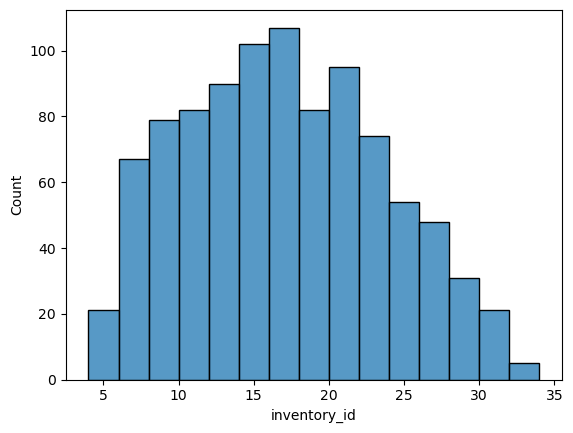

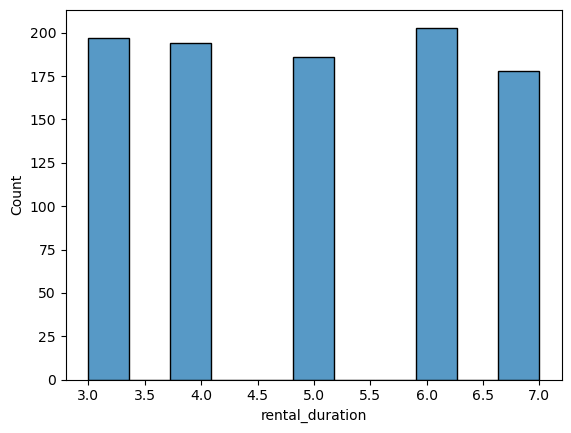

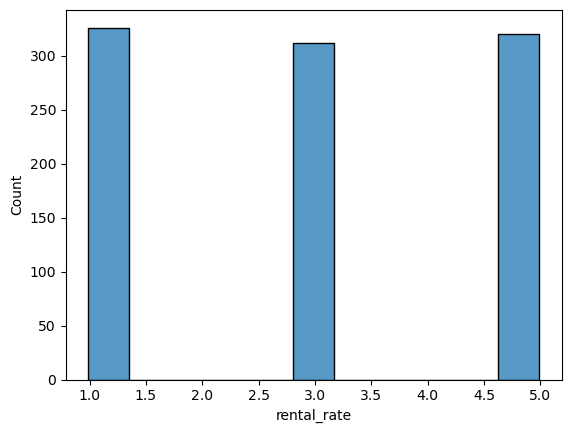

In [20]:
##### import matplotlib.pyplot as plt
import seaborn as sns

def plot_hist(df):
    list_of_ncolumns = list(df.select_dtypes(np.number))
    #list with numeric columns names
    for col in list_of_ncolumns:
        sns.histplot(df[col])
        plt.show()
        
plot_hist(x)

### X-y Split

In [35]:
X=agg_data.drop(['yes_no'], axis=1)
y=agg_data['yes_no']


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [38]:
X_train_num = X_train.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes('object')
X_test_num = X_test.select_dtypes(np.number)
X_test_cat = X_test.select_dtypes('object')

In [39]:
X_train_num

,film_id,inventory_id,rental_duration,rental_rate
849,887,19,5,4.99
537,563,30,6,4.99
619,647,19,4,0.99
547,573,13,6,2.99
185,200,26,7,0.99
...,...,...,...,...
440,464,15,3,2.99
165,177,13,4,4.99
7,8,18,6,4.99
219,236,14,4,2.99


In [40]:
encoder = OneHotEncoder()
encoder.fit(X_train_cat)
X_train_cat_encoded = encoder.transform(X_train_cat).toarray() 
cols = encoder.get_feature_names_out(input_features=X_train_cat.columns)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns=cols)
X_train_cat_encoded.head()

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


In [41]:
X_test_cat_encoded = encoder.transform(X_test_cat).toarray() 
cols = encoder.get_feature_names_out(input_features=X_test_cat.columns)
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns=cols) 
X_test_cat_encoded.head()

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0


In [42]:
standardScaler = StandardScaler().fit(X_train_num)
X_train_num_standardized = standardScaler.transform(X_train_num)
X_train_num_standardized = pd.DataFrame(X_train_num_standardized, columns=X_train_num.columns)

In [43]:
X_train_recombined = pd.concat([X_train_num_standardized, X_train_cat_encoded], axis=1)

In [44]:
X_test_num_standardized = standardScaler.transform(X_test_num)
X_test_num_standardized=pd.DataFrame(X_test_num_standardized, columns=X_test_num.columns)

In [45]:
X_test_recombined = pd.concat([X_test_num_standardized, X_test_cat_encoded], axis=1)

In [47]:
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_recombined, y_train)
classification

LogisticRegression(multi_class='multinomial', random_state=0)

In [48]:
y_train_pred = classification.predict(X_train_recombined)
classification.score(X_train_recombined, y_train)

0.9930362116991643

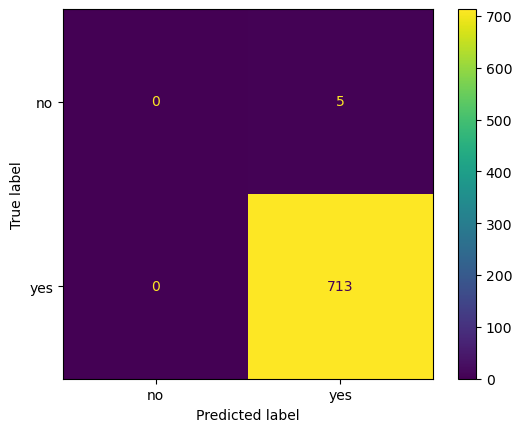

In [60]:
ConfusionMatrixDisplay(conf_matrix, display_labels=classification.classes_).plot()

### Confusion matrixs on Test set

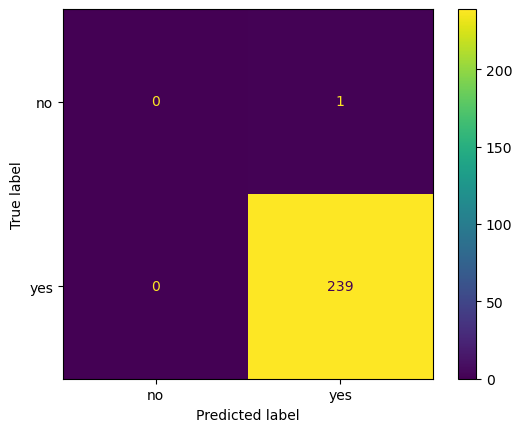

In [64]:
conf_test = confusion_matrix(y_test, y_test_pred)
conf_test
disp = ConfusionMatrixDisplay(conf_test,display_labels=classification.classes_);
disp.plot()
plt.show()